In [73]:
import bs4
import urllib3
import time
import pandas as pd
import numpy as np
import warnings

#spacy

from keras.preprocessing import text, sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Model, load_model, model_from_json
from keras.metrics import binary_accuracy

from keras.utils.vis_utils import model_to_dot, plot_model
from keras.layers import (Reshape, Lambda, Dropout, Input, Embedding, Dense, Conv1D, Conv2D, MaxPooling1D,
                          concatenate, Flatten, Permute, RepeatVector, CuDNNLSTM,CuDNNGRU, SpatialDropout1D, LSTM)
from keras import optimizers
from keras.callbacks import EarlyStopping,Callback

from tensorflow.keras.callbacks import TensorBoard

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score,classification_report
#from sklearn import metrics

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import RegexpTokenizer
import nltk

#graficos:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### defino clases

In [2]:

p_clases = ["Política", "Turismo", "Economía"]
p_target = "seccion"


articulos = pd.DataFrame()

articulos = pd.read_csv("./TP1_articulos_all.csv")
print("Articulos :", len(articulos))


Articulos : 107877


# Tratamiento del dataset

In [3]:
articulos.head(5)

,ID,url,titulo1,titulo,seccion,fecha,autor,tags,texto
0,0,http://www.lanacion.com.ar/112790-de-la-rua-y-...,"De la Rúa y Prodi, en la ""tercera vía""","('De la Rúa y Prodi, en la tercera vía',)",Política,03/10/1998 12:00:00 a.m.,[''],[''],\nROMA.- En el último día de su visita a Itali...
1,1,http://www.lanacion.com.ar/112779-un-viejo-ami...,Un viejo amigo de Erman González,"('Un viejo amigo de Erman González',)",Política,03/10/1998 12:00:00 a.m.,[''],[''],\nLuis Sarlenga es el segundo detenido por los...
2,2,http://www.lanacion.com.ar/112778-armas-sarlen...,Armas: Sarlenga quedó detenido,"('Armas: Sarlenga quedó detenido',)",Política,03/10/1998 12:00:00 a.m.,['Adrián Ventura'],[''],\nEl ex director de Fabricaciones Militares Lu...
3,3,http://www.lanacion.com.ar/112787-sorpresa-ent...,Sorpresa entre los políticos chilenos,"('Sorpresa entre los políticos chilenos',)",Política,03/10/1998 12:00:00 a.m.,[''],[''],"\nSANTIAGO, Chile.- El vuelco de la diplomacia..."
4,4,http://www.lanacion.com.ar/112780-el-foro-de-g...,El Foro de Generales Retirados cuestionó las i...,('El Foro de Generales Retirados cuestionó las...,Política,03/10/1998 12:00:00 a.m.,[''],[''],\nEn la última reunión del Foro de Generales R...


In [4]:
articulos[[p_target,"fecha"]].groupby([p_target]).count().sort_values(["fecha"], ascending = False)

,fecha
seccion,
Economía,46809
Política,46801
Turismo,14243
LA NACION revista,14
Información general,5
Espectáculos,2
Sociedad,2
Comercio exterior,1


In [5]:
#reemplaza las otras clases por "otro"
articulos[p_target] = [clase if clase in p_clases else "Otro" for clase in articulos[p_target]]

In [6]:
articulos[[p_target,"titulo"]].groupby(p_target).count()

,titulo
seccion,
Economía,46809
Otro,24
Política,46801
Turismo,14243


### elimina duplicados

In [7]:
print(len(articulos))
#articulos = articulos.drop("ID",axis = 1)
articulos = articulos.drop_duplicates()
print(len(articulos))

107877
107877


### Genera las Dummies

In [8]:
articulos = pd.concat([articulos,pd.get_dummies(articulos[p_target])[p_clases]], axis = 1)

In [9]:
articulos.head(5)

,ID,url,titulo1,titulo,seccion,fecha,autor,tags,texto,Política,Turismo,Economía
0,0,http://www.lanacion.com.ar/112790-de-la-rua-y-...,"De la Rúa y Prodi, en la ""tercera vía""","('De la Rúa y Prodi, en la tercera vía',)",Política,03/10/1998 12:00:00 a.m.,[''],[''],\nROMA.- En el último día de su visita a Itali...,1,0,0
1,1,http://www.lanacion.com.ar/112779-un-viejo-ami...,Un viejo amigo de Erman González,"('Un viejo amigo de Erman González',)",Política,03/10/1998 12:00:00 a.m.,[''],[''],\nLuis Sarlenga es el segundo detenido por los...,1,0,0
2,2,http://www.lanacion.com.ar/112778-armas-sarlen...,Armas: Sarlenga quedó detenido,"('Armas: Sarlenga quedó detenido',)",Política,03/10/1998 12:00:00 a.m.,['Adrián Ventura'],[''],\nEl ex director de Fabricaciones Militares Lu...,1,0,0
3,3,http://www.lanacion.com.ar/112787-sorpresa-ent...,Sorpresa entre los políticos chilenos,"('Sorpresa entre los políticos chilenos',)",Política,03/10/1998 12:00:00 a.m.,[''],[''],"\nSANTIAGO, Chile.- El vuelco de la diplomacia...",1,0,0
4,4,http://www.lanacion.com.ar/112780-el-foro-de-g...,El Foro de Generales Retirados cuestionó las i...,('El Foro de Generales Retirados cuestionó las...,Política,03/10/1998 12:00:00 a.m.,[''],[''],\nEn la última reunión del Foro de Generales R...,1,0,0


#### convierto el campo "texto" a minuscula

In [10]:
articulos["texto"] = [art.lower() for art in articulos["texto"]]

In [11]:
#traigo las stop words de la libreria
cachedStopWords = stopwords.words("spanish")

### Steaming

#### le hace el tratamiento a todas las palabras del campo "texto" (excluyendo las Stop words antes definidas)

In [12]:

stemmer = SnowballStemmer('spanish')
regexp_tokenizer = RegexpTokenizer(r'\w+')

stemmed_text = [' '.join([stemmer.stem(word) for word in regexp_tokenizer.tokenize(text) if word not in cachedStopWords]) for text in articulos["texto"]]

In [ ]:
### voy a guardar el dataset con el stemmen aplicado
stemmed_text

In [14]:
articulos["texto"] = stemmed_text

In [15]:
articulos.head()

,ID,url,titulo1,titulo,seccion,fecha,autor,tags,texto,Política,Turismo,Economía
0,0,http://www.lanacion.com.ar/112790-de-la-rua-y-...,"De la Rúa y Prodi, en la ""tercera vía""","('De la Rúa y Prodi, en la tercera vía',)",Política,03/10/1998 12:00:00 a.m.,[''],[''],rom ultim dia visit itali fern rua asegur reto...,1,0,0
1,1,http://www.lanacion.com.ar/112779-un-viejo-ami...,Un viejo amigo de Erman González,"('Un viejo amigo de Erman González',)",Política,03/10/1998 12:00:00 a.m.,[''],[''],luis sarleng segund deten envi ilegal armas cr...,1,0,0
2,2,http://www.lanacion.com.ar/112778-armas-sarlen...,Armas: Sarlenga quedó detenido,"('Armas: Sarlenga quedó detenido',)",Política,03/10/1998 12:00:00 a.m.,['Adrián Ventura'],[''],ex director fabric militar luis sarleng deten ...,1,0,0
3,3,http://www.lanacion.com.ar/112787-sorpresa-ent...,Sorpresa entre los políticos chilenos,"('Sorpresa entre los políticos chilenos',)",Política,03/10/1998 12:00:00 a.m.,[''],[''],santiag chil vuelc diplomaci chilen anunci ela...,1,0,0
4,4,http://www.lanacion.com.ar/112780-el-foro-de-g...,El Foro de Generales Retirados cuestionó las i...,('El Foro de Generales Retirados cuestionó las...,Política,03/10/1998 12:00:00 a.m.,[''],[''],ultim reunion for general retir analiz implic ...,1,0,0


### guardo el dataset con el Steaming

In [16]:
articulos.to_csv("./TP1_articulos_stemmed.csv")

# levanto el csv con el stemming ya pasado

In [8]:
articulos_upload = pd.DataFrame()
articulos_upload= pd.read_csv("./TP1_articulos_stemmed.csv")
articulos_upload.head(5)

,Unnamed: 0,ID,url,titulo1,titulo,seccion,fecha,autor,tags,texto,Política,Turismo,Economía
0,0,0,http://www.lanacion.com.ar/112790-de-la-rua-y-...,"De la Rúa y Prodi, en la ""tercera vía""","('De la Rúa y Prodi, en la tercera vía',)",Política,03/10/1998 12:00:00 a.m.,[''],[''],rom ultim dia visit itali fern rua asegur reto...,1,0,0
1,1,1,http://www.lanacion.com.ar/112779-un-viejo-ami...,Un viejo amigo de Erman González,"('Un viejo amigo de Erman González',)",Política,03/10/1998 12:00:00 a.m.,[''],[''],luis sarleng segund deten envi ilegal armas cr...,1,0,0
2,2,2,http://www.lanacion.com.ar/112778-armas-sarlen...,Armas: Sarlenga quedó detenido,"('Armas: Sarlenga quedó detenido',)",Política,03/10/1998 12:00:00 a.m.,['Adrián Ventura'],[''],ex director fabric militar luis sarleng deten ...,1,0,0
3,3,3,http://www.lanacion.com.ar/112787-sorpresa-ent...,Sorpresa entre los políticos chilenos,"('Sorpresa entre los políticos chilenos',)",Política,03/10/1998 12:00:00 a.m.,[''],[''],santiag chil vuelc diplomaci chilen anunci ela...,1,0,0
4,4,4,http://www.lanacion.com.ar/112780-el-foro-de-g...,El Foro de Generales Retirados cuestionó las i...,('El Foro de Generales Retirados cuestionó las...,Política,03/10/1998 12:00:00 a.m.,[''],[''],ultim reunion for general retir analiz implic ...,1,0,0


In [10]:
articulos=0

## define dataset de train y test, ademas el tipo de sampleo

In [11]:
test_size = 0.3
articulos_X = articulos_upload.texto
articulos_y=articulos_upload[p_clases]

articulos_train, articulos_test, articulos_train_y, articulos_test_y = train_test_split(articulos_upload, articulos_y, 
                                                                                            test_size=test_size, random_state=42, 
                                                                                            stratify = articulos_y, shuffle = True)
articulos_train_X = articulos_train.texto.astype(str)
articulos_test_X = articulos_test.texto


In [12]:
articulos_test.texto

86627     ofert reduc inferior suel ser corrient apertur...
72671     carrer preci 2003 clar ganador sector construc...
58532     especial pais sudest asiat tir primer piedr si...
60374     aunqu rest 18 mes reconoc oficial semestr difi...
76827     ministr econom felis miceli expres ayer termin...
92278     merc golp va 2012 vem fin año volatil embarg a...
41310     ex integr conadep ex funcionari gobiern alianz...
48361     aug turism prolifer festival combin propuest a...
32487     ex cancill dant caput proclam anteay precandid...
77851     reuters confianz consumidor argentin mejor 0 2...
43522     mientr pian pued qued cualqui lad pian torrent...
72038     si alianz southern winds sw empres aere estata...
20343     plat movimient popul 29 may mp 29 17 diciembr ...
61647     pregunt final provoc dud dij carl pellegrini l...
58481     ayer pus march concili obligatori nuev instanc...
40702     secretari general union tranviari automotor ut...
25353     medi polem sospech boicot chin

### Aplico Tokenizer

In [13]:
max_features = 3000
maxlen = 450
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(articulos_upload["texto"].astype(str))
#save_text_tokenizer(object, filename)

## tokenizador de palabras

#load_text_tokenizer(filename)

X_train = tokenizer.texts_to_sequences(articulos_train_X)
X_test = tokenizer.texts_to_sequences(articulos_test_X)
X_train = pad_sequences(X_train,maxlen)
X_test = pad_sequences(X_test,maxlen)

In [14]:
y_train = articulos_train_y[p_clases]
y_test = articulos_test_y[p_clases]

In [16]:
print("Articulos :", len(articulos_upload))
print("train :", len(X_train))
print("test :", len(X_test))


Articulos : 107877
train : 75513
test : 32364


### defino parametros de la red

In [17]:
epochs = 100
embedding_size = int(max_features**(1/4))

# LSTM
lstm_output_size = 50
NAME = "lanacion_seccion_1"
tensorboard = TensorBoard(log_dir="/mnt/tflogs/{}".format(NAME))


### genera los pesos (dividir por el total de palabras por clase)


In [18]:
#get Weights


#total_samples = articulos_train[p_target].count()
class_weights =  1 / articulos_train[[p_target,"titulo"]].groupby(p_target).count() 
class_weights = class_weights.reset_index()
weights = np.array([class_weights[class_weights[p_target]==clase]["titulo"].iloc[0] for clase in articulos_train[p_target]])

In [19]:
## aca hay que guardar los pesos

In [20]:
val_weights = np.array([class_weights[class_weights[p_target]==clase]["titulo"].iloc[0] for clase in articulos_test[p_target]])

#### define la funcion para armar la ROC

In [21]:

class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))



In [22]:
model_input = Input(shape=(X_train.shape[1],),name='main_input', dtype='float32')
print(model_input.shape)
filter_sizes = [1,2,3,5]
num_filters = 32


(?, 450)


### Estructura de la Red

In [24]:

def get_model():    
    
    x = Embedding(max_features, embedding_size)(model_input)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(50,activation="relu")(x)
    #x = Dropout(20)(x)
    #x = Dense(40,activation="relu")(x)
    main_output = Dense(y_train.shape[1], activation='softmax', name='main_output')(x)


    model = Model(inputs=model_input, outputs=main_output)

    callback = EarlyStopping(monitor='val_acc',
                                  min_delta=0,
                                  patience=4,
                                  verbose=0, mode='auto')

    #roc_cbk = roc_callback(training_data=None,validation_data=(X_test,y_test), #, y_test),
    #                           early_stopping= True, patience=20, min_delta=0.0001, 
    #                           checkpoint_file = p_model_version+'_weights.hdf5')   
    callbacks_list = [callback]


    model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=["accuracy"])


    return model


In [25]:

model = get_model()

In [26]:

callback = EarlyStopping(monitor='val_acc',
                              min_delta=0,
                              patience=4,
                              verbose=0, mode='auto')

#roc_cbk = roc_callback(training_data=None,validation_data=(X_test,y_test), #, y_test),
#                           early_stopping= True, patience=20, min_delta=0.0001, 
#                           checkpoint_file = p_model_version+'_weights.hdf5')   
callbacks_list = [callback]


In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 450)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 450, 7)            21000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 450, 7)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3150)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                157550    
_________________________________________________________________
main_output (Dense)          (None, 3)                 153       
Total params: 178,703
Trainable params: 178,703
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.fit(X_train, y_train,validation_data=(X_test,y_test,val_weights), epochs=20, batch_size=256,  callbacks=callbacks_list,
         sample_weight = weights)


Train on 75513 samples, validate on 32364 samples
Epoch 1/20
75513/75513 [==============================] - 78s 1ms/step - loss: 4.2905e-05 - acc: 0.3982 - val_loss: 3.9601e-05 - val_acc: 0.5104
Epoch 2/20
75513/75513 [==============================] - 71s 943us/step - loss: 1.9232e-05 - acc: 0.7975 - val_loss: 9.9079e-06 - val_acc: 0.8956
Epoch 3/20
75513/75513 [==============================] - 72s 958us/step - loss: 9.0227e-06 - acc: 0.9003 - val_loss: 8.2880e-06 - val_acc: 0.9125
Epoch 4/20
75513/75513 [==============================] - 72s 948us/step - loss: 7.8483e-06 - acc: 0.9124 - val_loss: 7.7127e-06 - val_acc: 0.9158
Epoch 5/20
75513/75513 [==============================] - 69s 916us/step - loss: 7.2759e-06 - acc: 0.9180 - val_loss: 7.3987e-06 - val_acc: 0.9187
Epoch 6/20
75513/75513 [==============================] - 78s 1ms/step - loss: 6.8045e-06 - acc: 0.9224 - val_loss: 7.2461e-06 - val_acc: 0.9219
Epoch 7/20
75513/75513 [==============================] - 71s 942us/step

In [30]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)


In [31]:
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 

Saved model to disk


In [32]:

prediction = model.predict(X_test)
display(articulos_test.head())



,Unnamed: 0,ID,url,titulo1,titulo,seccion,fecha,autor,tags,texto,Política,Turismo,Economía
86627,86627,86627,http://www.lanacion.com.ar/1270520-moderado-in...,Moderado interés de la demanda,"('Moderado interés de la demanda',)",Economía,01/06/2010 12:00:00 a.m.,[''],['Comunidad de Negocios'],ofert reduc inferior suel ser corrient apertur...,0,0,1
72671,72671,72671,http://www.lanacion.com.ar/561893-la-mayor-alz...,La mayor alza la registró la construcción,"('La mayor alza la registró la construcción',)",Economía,08/01/2004 12:00:00 a.m.,[''],['Comunidad de Negocios'],carrer preci 2003 clar ganador sector construc...,0,0,1
58532,58532,58532,http://www.lanacion.com.ar/76342-los-mercados-...,Los mercados del sudeste asiático presentan un...,('Los mercados del sudeste asiático presentan ...,Economía,07/09/1997 12:00:00 a.m.,['Luis Cortina'],['Comunidad de Negocios'],especial pais sudest asiat tir primer piedr si...,0,0,1
60374,60374,60374,http://www.lanacion.com.ar/101838-un-complicad...,Un complicado segundo semestre en el país global,('Un complicado segundo semestre en el país gl...,Economía,01/07/1998 12:00:00 a.m.,[''],['Comunidad de Negocios'],aunqu rest 18 mes reconoc oficial semestr difi...,0,0,1
76827,76827,76827,http://www.lanacion.com.ar/762521-economia-qui...,Economía quiere retrotraer a noviembre el valo...,('Economía quiere retrotraer a noviembre el va...,Economía,06/12/2005 12:00:00 a.m.,['Franco Varise'],['Comunidad de Negocios'],ministr econom felis miceli expres ayer termin...,0,0,1


In [33]:

resultado = pd.concat([articulos_test[[p_target, "titulo"]].reset_index(), pd.DataFrame(prediction)],ignore_index=1, axis = 1 )
resultado.columns = ["id", p_target, "titulo"] + list(y_test.columns)
resultado.head()

,id,seccion,titulo,Política,Turismo,Economía
0,86627,Economía,"('Moderado interés de la demanda',)",0.000823,8.786867e-06,0.999168
1,72671,Economía,"('La mayor alza la registró la construcción',)",0.049318,1.057231e-04,0.950576
2,58532,Economía,('Los mercados del sudeste asiático presentan ...,0.018491,8.634078e-07,0.981508
3,60374,Economía,('Un complicado segundo semestre en el país gl...,0.303516,2.781217e-07,0.696483
4,76827,Economía,('Economía quiere retrotraer a noviembre el va...,0.058816,3.031775e-09,0.941184


In [34]:
len(resultado)

32364

# Resultados del modelo
### solo analiza arrays

https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Consumer_complaints.ipynb


http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

In [35]:

# levanto el modeo ya entrenado
 
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [36]:
X_test

array([[   0,    0,    0, ...,   73,  234,  391],
       [   0,    0,    0, ..., 1543,  103,   45],
       [  63,  703,   22, ...,  261,  374,   27],
       ...,
       [   0,    0,    0, ...,  270,  246,  966],
       [   0,    0,    0, ...,  194, 1275,  233],
       [   0,    0,    0, ..., 2003,  109, 2296]], dtype=int32)

In [37]:
prediction_loaded = loaded_model.predict(X_test)
resultado_loaded = pd.concat([articulos_test[[p_target, "titulo"]].reset_index(), pd.DataFrame(prediction_loaded)],ignore_index=1, axis = 1 )
resultado_loaded.columns = ["id", p_target, "titulo"] + list(y_test.columns)
resultado_loaded.head(10)

,id,seccion,titulo,Política,Turismo,Economía
0,86627,Economía,"('Moderado interés de la demanda',)",0.000823,8.786867e-06,0.999168
1,72671,Economía,"('La mayor alza la registró la construcción',)",0.049318,1.057231e-04,0.950576
2,58532,Economía,('Los mercados del sudeste asiático presentan ...,0.018491,8.634078e-07,0.981508
3,60374,Economía,('Un complicado segundo semestre en el país gl...,0.303516,2.781217e-07,0.696483
4,76827,Economía,('Economía quiere retrotraer a noviembre el va...,0.058816,3.031775e-09,0.941184
5,92278,Economía,"('Cómo es el portafolio de',)",0.004763,6.406920e-03,0.988830
6,41310,Política,('Graciela Fernández Meijide: De Macri nunca e...,0.993836,2.761261e-06,0.006161
7,48361,Turismo,"('Carlos Keen, de festival',)",0.000010,9.999840e-01,0.000006
8,32487,Política,('Peligra el acuerdo del FAP y la UCR en provi...,0.999878,1.437886e-08,0.000122
9,77851,Economía,('Mejóro en mayo la confianza de los consumido...,0.051853,2.018895e-04,0.947945


In [39]:
prediction_loaded

array([[8.2291925e-04, 8.7868666e-06, 9.9916828e-01],
       [4.9318254e-02, 1.0572309e-04, 9.5057601e-01],
       [1.8490704e-02, 8.6340776e-07, 9.8150843e-01],
       ...,
       [2.3735962e-03, 5.9475191e-05, 9.9756694e-01],
       [9.9993253e-01, 9.6490094e-10, 6.7514302e-05],
       [7.3683411e-03, 2.1888461e-04, 9.9241275e-01]], dtype=float32)

#### Convierto el y_test a un array

In [40]:
y_test_array = y_test.values

#### Aplico la funcion argmax(axis=1) a ambos array para que me de la ubicacion del maximo de cada linea

In [41]:
y_test_array_clase=y_test_array.argmax(axis=1)
y_prediction_clase=prediction_loaded.argmax(axis=1)

In [42]:
accuracy_score(y_test_array_clase, y_prediction_clase )

0.9268940798417995

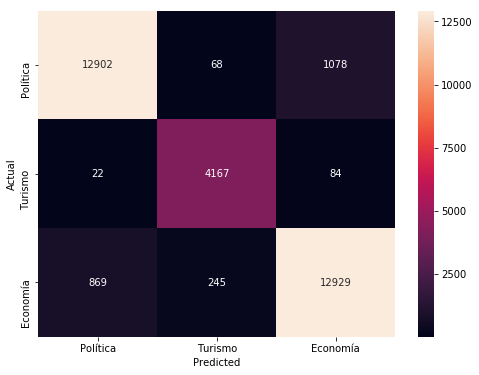

In [43]:
#y_pred = model.predict(X_test)

conf_mat = confusion_matrix(y_test_array_clase, y_prediction_clase)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=p_clases, yticklabels=p_clases)
           
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [44]:

print(classification_report(y_test_array_clase, y_prediction_clase, 
                                    target_names=p_clases))

             precision    recall  f1-score   support

   Política       0.94      0.92      0.93     14048
    Turismo       0.93      0.98      0.95      4273
   Economía       0.92      0.92      0.92     14043

avg / total       0.93      0.93      0.93     32364



In [45]:
roc_auc_score(y_test_array, prediction_loaded, average='macro', sample_weight=None)#, max_fpr=None)

0.9856089210542843

# Validación con noticias de 2018

In [46]:
p_clases = ["Política", "Turismo", "Economía"]
p_target = "seccion"

articulos_validacion = pd.DataFrame()

articulos_validacion = pd.read_csv("./validacion_tp/validacion_lanacion_final.csv")
print("Articulos :", len(articulos_validacion))

Articulos : 3987


In [47]:
#articulos_validacion= pd.read_csv("./TP1_articulos_stemmed.csv")

In [48]:
articulos_validacion

,ID,url,titulo1,titulo,seccion,fecha,autor,tags,texto
0,0,http://www.lanacion.com.ar/2097028-anuncian-es...,Anuncian esta semana una suba de los boletos d...,('Anuncian esta semana una suba de los boletos...,Economía,01/01/2018 08:43:00 p.m.,['Francisco Jueguen'],"['Guillermo Dietrich', 'Tránsito y transporte'...",Luego de un año de elecciones en el que no se ...
1,1,http://www.lanacion.com.ar/2097115-el-gobierno...,El Gobierno pisó el freno de la inversión en o...,('El Gobierno pisó el freno de la inversión en...,Economía,02/01/2018 12:00:00 a.m.,['Pablo Fernández Blanco'],"['Titulo centrado', 'Actividad económica', 'Po...",Las elecciones tienen sobre la inversión públi...
2,2,http://www.lanacion.com.ar/2097092-por-el-repu...,"Por el repunte de Brasil, las automotrices est...","('Por el repunte de Brasil, las automotrices e...",Economía,02/01/2018 12:00:00 a.m.,['Gabriela Origlia '],"['Actividad económica', 'Comunidad de Negocios...",CÓRDOBA.- El inicio del año para las automotri...
3,3,http://www.lanacion.com.ar/2097095-entre-manan...,Entre mañana y el jueves anuncian subas en tre...,('Entre mañana y el jueves anuncian subas en t...,Economía,02/01/2018 12:00:00 a.m.,['Francisco Jueguen'],"['Actividad económica', 'Comunidad de Negocios...",Luego de un año de elecciones en el que no se ...
4,4,http://www.lanacion.com.ar/2097094-fadea-estre...,"Fadea estrena conducción, pero mantiene sus pl...","('Fadea estrena conducción, pero mantiene sus ...",Economía,02/01/2018 12:00:00 a.m.,['Gabriela Origlia '],"['Actividad económica', 'Comunidad de Negocios']",CÓRDOBA.- La Fábrica de Aviones Brigadier San ...
5,5,http://www.lanacion.com.ar/2097037-sube-el-def...,Sube el déficit energético y llega a US$ 3124 ...,('Sube el déficit energético y llega a US$ 312...,Economía,02/01/2018 12:00:00 a.m.,['Redacción LA NACION'],"['Actividad económica', 'Comunidad de Negocios']",El déficit comercial energético en los primero...
6,6,http://www.lanacion.com.ar/2096953-vacaciones-...,Vacaciones unplugged: cómo proteger nuestro de...,('Vacaciones unplugged: cómo proteger nuestro ...,Economía,02/01/2018 12:26:00 a.m.,['Andrea Churba'],"['Nota de Opinion', 'Comunidad de Negocios', '...","Llega el verano, y con él la cuenta regresiva ..."
7,7,http://www.lanacion.com.ar/2097118-como-setear...,Como setear tus metas financieras para 2018,"('Como setear tus metas financieras para 2018',)",Economía,02/01/2018 02:00:00 a.m.,['Nicolás Litvinoff'],"['Finanzas', 'Nota de Opinion', 'Política']",Cada comienzo de año nos encuentra sumergidos ...
8,8,http://www.lanacion.com.ar/2097165-el-dolar-co...,El dólar cotizó a la baja en el primer día del...,('El dólar cotizó a la baja en el primer día d...,Economía,01/01/2018 11:00:00 a.m.,['Javier Blanco'],"['Dólar hoy', 'Comunidad de Negocios']",Tras haber avanzado un 17% durante el año pasa...
9,9,http://www.lanacion.com.ar/2097155-dicen-que-a...,Afirman que Apple podría comprar Netflix por U...,('Afirman que Apple podría comprar Netflix por...,Economía,02/01/2018 01:27:00 p.m.,['Redacción LA NACION'],"['Negocios', 'Comunidad de Negocios', 'Sports ...",Cuando todavía no transcurrieron tres semanas ...


In [49]:
articulos_validacion[[p_target,"fecha"]].groupby([p_target]).count().sort_values(["fecha"], ascending = False)

,fecha
seccion,
Economía,1868
Política,1834
Turismo,284
Revista-Lugares,1


### tengo que aplicarle las mismas transformaciones que al dataset de entrenamiento:
    1. reemplaza el resto de las clases por "otro" y genero las dummies
    2. Pasa el campo "texto" a minuscula y trae las stop words
    3. Steaming
    4. aplico el Token que utilice en train
    5. genera los pesos
    (donde aplica el maximo de palabras por linea?

In [50]:
#reemplaza las otras clases por "otro"
articulos_validacion[p_target] = [clase if clase in p_clases else "Otro" for clase in articulos_validacion[p_target]]
#elimina duplicados

In [51]:
articulos_validacion

,ID,url,titulo1,titulo,seccion,fecha,autor,tags,texto
0,0,http://www.lanacion.com.ar/2097028-anuncian-es...,Anuncian esta semana una suba de los boletos d...,('Anuncian esta semana una suba de los boletos...,Economía,01/01/2018 08:43:00 p.m.,['Francisco Jueguen'],"['Guillermo Dietrich', 'Tránsito y transporte'...",Luego de un año de elecciones en el que no se ...
1,1,http://www.lanacion.com.ar/2097115-el-gobierno...,El Gobierno pisó el freno de la inversión en o...,('El Gobierno pisó el freno de la inversión en...,Economía,02/01/2018 12:00:00 a.m.,['Pablo Fernández Blanco'],"['Titulo centrado', 'Actividad económica', 'Po...",Las elecciones tienen sobre la inversión públi...
2,2,http://www.lanacion.com.ar/2097092-por-el-repu...,"Por el repunte de Brasil, las automotrices est...","('Por el repunte de Brasil, las automotrices e...",Economía,02/01/2018 12:00:00 a.m.,['Gabriela Origlia '],"['Actividad económica', 'Comunidad de Negocios...",CÓRDOBA.- El inicio del año para las automotri...
3,3,http://www.lanacion.com.ar/2097095-entre-manan...,Entre mañana y el jueves anuncian subas en tre...,('Entre mañana y el jueves anuncian subas en t...,Economía,02/01/2018 12:00:00 a.m.,['Francisco Jueguen'],"['Actividad económica', 'Comunidad de Negocios...",Luego de un año de elecciones en el que no se ...
4,4,http://www.lanacion.com.ar/2097094-fadea-estre...,"Fadea estrena conducción, pero mantiene sus pl...","('Fadea estrena conducción, pero mantiene sus ...",Economía,02/01/2018 12:00:00 a.m.,['Gabriela Origlia '],"['Actividad económica', 'Comunidad de Negocios']",CÓRDOBA.- La Fábrica de Aviones Brigadier San ...
5,5,http://www.lanacion.com.ar/2097037-sube-el-def...,Sube el déficit energético y llega a US$ 3124 ...,('Sube el déficit energético y llega a US$ 312...,Economía,02/01/2018 12:00:00 a.m.,['Redacción LA NACION'],"['Actividad económica', 'Comunidad de Negocios']",El déficit comercial energético en los primero...
6,6,http://www.lanacion.com.ar/2096953-vacaciones-...,Vacaciones unplugged: cómo proteger nuestro de...,('Vacaciones unplugged: cómo proteger nuestro ...,Economía,02/01/2018 12:26:00 a.m.,['Andrea Churba'],"['Nota de Opinion', 'Comunidad de Negocios', '...","Llega el verano, y con él la cuenta regresiva ..."
7,7,http://www.lanacion.com.ar/2097118-como-setear...,Como setear tus metas financieras para 2018,"('Como setear tus metas financieras para 2018',)",Economía,02/01/2018 02:00:00 a.m.,['Nicolás Litvinoff'],"['Finanzas', 'Nota de Opinion', 'Política']",Cada comienzo de año nos encuentra sumergidos ...
8,8,http://www.lanacion.com.ar/2097165-el-dolar-co...,El dólar cotizó a la baja en el primer día del...,('El dólar cotizó a la baja en el primer día d...,Economía,01/01/2018 11:00:00 a.m.,['Javier Blanco'],"['Dólar hoy', 'Comunidad de Negocios']",Tras haber avanzado un 17% durante el año pasa...
9,9,http://www.lanacion.com.ar/2097155-dicen-que-a...,Afirman que Apple podría comprar Netflix por U...,('Afirman que Apple podría comprar Netflix por...,Economía,02/01/2018 01:27:00 p.m.,['Redacción LA NACION'],"['Negocios', 'Comunidad de Negocios', 'Sports ...",Cuando todavía no transcurrieron tres semanas ...


In [52]:
#dummies
articulos_validacion = pd.concat([articulos_validacion,pd.get_dummies(articulos_validacion[p_target])[p_clases]], axis = 1)

In [53]:
print(len(articulos_validacion))
#articulos = articulos.drop("ID",axis = 1)
articulos_validacion = articulos_validacion.drop_duplicates()
print(len(articulos_validacion))

3987
3987


In [54]:
articulos_validacion.head(5)

,ID,url,titulo1,titulo,seccion,fecha,autor,tags,texto,Política,Turismo,Economía
0,0,http://www.lanacion.com.ar/2097028-anuncian-es...,Anuncian esta semana una suba de los boletos d...,('Anuncian esta semana una suba de los boletos...,Economía,01/01/2018 08:43:00 p.m.,['Francisco Jueguen'],"['Guillermo Dietrich', 'Tránsito y transporte'...",Luego de un año de elecciones en el que no se ...,0,0,1
1,1,http://www.lanacion.com.ar/2097115-el-gobierno...,El Gobierno pisó el freno de la inversión en o...,('El Gobierno pisó el freno de la inversión en...,Economía,02/01/2018 12:00:00 a.m.,['Pablo Fernández Blanco'],"['Titulo centrado', 'Actividad económica', 'Po...",Las elecciones tienen sobre la inversión públi...,0,0,1
2,2,http://www.lanacion.com.ar/2097092-por-el-repu...,"Por el repunte de Brasil, las automotrices est...","('Por el repunte de Brasil, las automotrices e...",Economía,02/01/2018 12:00:00 a.m.,['Gabriela Origlia '],"['Actividad económica', 'Comunidad de Negocios...",CÓRDOBA.- El inicio del año para las automotri...,0,0,1
3,3,http://www.lanacion.com.ar/2097095-entre-manan...,Entre mañana y el jueves anuncian subas en tre...,('Entre mañana y el jueves anuncian subas en t...,Economía,02/01/2018 12:00:00 a.m.,['Francisco Jueguen'],"['Actividad económica', 'Comunidad de Negocios...",Luego de un año de elecciones en el que no se ...,0,0,1
4,4,http://www.lanacion.com.ar/2097094-fadea-estre...,"Fadea estrena conducción, pero mantiene sus pl...","('Fadea estrena conducción, pero mantiene sus ...",Economía,02/01/2018 12:00:00 a.m.,['Gabriela Origlia '],"['Actividad económica', 'Comunidad de Negocios']",CÓRDOBA.- La Fábrica de Aviones Brigadier San ...,0,0,1


In [55]:
### texto a min
articulos_validacion["texto"] = [art.lower() for art in articulos_validacion["texto"]]

In [56]:
#traigo las stop words de la libreria
cachedStopWords = stopwords.words("spanish")

In [57]:
##steamming

stemmer = SnowballStemmer('spanish')
regexp_tokenizer = RegexpTokenizer(r'\w+')

stemmed_text = [' '.join([stemmer.stem(word) for word in regexp_tokenizer.tokenize(text) if word not in cachedStopWords]) for text in articulos_validacion["texto"]]

In [58]:
articulos_validacion["texto"] = stemmed_text

test_size = 0.99
articulos_X = articulos_validacion["texto"]
articulos_y=articulos_validacion[p_clases]

articulos_train, articulos_test, articulos_train_y, articulos_test_y = train_test_split(articulos, articulos_y, 
                                                                                            test_size=test_size, random_state=42, 
                                                                                            stratify = articulos_y, shuffle = True)
articulos_train_X = articulos_train["texto"]
articulos_test_X = articulos_test["texto"]


In [59]:
articulos_validacion.tail(5)

,ID,url,titulo1,titulo,seccion,fecha,autor,tags,texto,Política,Turismo,Economía
3982,3982,http://www.lanacion.com.ar/2178893-la-fit-pres...,Descuentos y ofertas para seguir viajando a pe...,('Descuentos y ofertas para seguir viajando a ...,Turismo,07/10/2018 12:00:00 a.m.,['Julieta Bilik'],"['Turismo', 'Viajes']",feri internacional turism amer latin fit lug s...,0,1,0
3983,3983,http://www.lanacion.com.ar/2178575-radiografia...,Radiografía del viajero argentino: cazador de ...,('Radiografía del viajero argentino: cazador d...,Turismo,07/10/2018 12:00:00 a.m.,['José Totah'],"['Turismo', 'Viajes']",si disting viajer argentin vorac ofert segun e...,0,1,0
3984,3984,http://www.lanacion.com.ar/2178581-museos-filt...,"Prendidos al celular, hasta en el museo","('Prendidos al celular, hasta en el museo',)",Turismo,07/10/2018 12:00:00 a.m.,['Carolina Reymúndez '],"['Viajes', 'Selfies', 'Museos']",mon lis huel sudor aleman mientr contempl axil...,0,1,0
3985,3985,http://www.lanacion.com.ar/2178582-circuitos-t...,Circuitos turísticos que ayudan a evitar impre...,('Circuitos turísticos que ayudan a evitar imp...,Turismo,07/10/2018 12:00:00 a.m.,['Julieta Bilik'],"['Turismo', 'Viajes']",almund principal portal viaj ofrec millon viaj...,0,1,0
3986,3986,http://www.lanacion.com.ar/2178576-claudio-ris...,"Claudio Rissi. ""Nunca pensé que el Coliseo me ...",('Claudio Rissi. Nunca pensé que el Coliseo me...,Turismo,07/10/2018 12:00:00 a.m.,['Alejandro Rapetti'],"['Turismo', 'Viajes', 'Entrevistas']",si seis años mam herman catamarc conoc abuel m...,0,1,0


In [60]:
print("Articulos :", len(articulos_validacion))
print("politica :", sum(articulos_validacion["Política"]))
print("econo :", sum(articulos_validacion["Economía"]))
#print("test :", len(X_test))

Articulos : 3987
politica : 1834
econo : 1868


In [61]:

test_size = 0.9
articulos_X =articulos_validacion.texto
articulos_y=articulos_validacion[p_clases]

articulos_test_X = articulos_validacion.texto

y_test = articulos_validacion[p_clases]

#articulos_test.texto
#articulos_validacion_X = articulos_validacion.texto.astype(str)
#y_valid=articulos_validacion[p_clases]
#y_valid

In [62]:
print("Articulos :", len(articulos_test_X))
print("Articulos :", len(y_test))

Articulos : 3987
Articulos : 3987


In [63]:
## tokenizador de palabras


X_valid = tokenizer.texts_to_sequences(articulos_test_X)
X_valid = pad_sequences(X_valid,maxlen)



#get Weights


#total_samples = articulos_train[p_target].count()
class_weights =  1 / articulos_train[[p_target,"titulo"]].groupby(p_target).count() 
class_weights = class_weights.reset_index()
weights = np.array([class_weights[class_weights[p_target]==clase]["titulo"].iloc[0] for clase in articulos_train[p_target]])

In [64]:

# later...
 
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [65]:
#loaded_model.predict(X_valid)

# la prediccion!

In [66]:
prediction_loaded = loaded_model.predict(X_valid)

In [67]:
resultado_loaded = pd.concat([articulos_validacion[[p_target, "titulo"]].reset_index(), pd.DataFrame(prediction_loaded)],ignore_index=1, axis = 1 )

In [68]:
resultado_loaded.head()

,0,1,2,3,4,5
0,0,Economía,('Anuncian esta semana una suba de los boletos...,0.047946,0.000021,0.952032
1,1,Economía,('El Gobierno pisó el freno de la inversión en...,0.242812,0.000020,0.757169
2,2,Economía,"('Por el repunte de Brasil, las automotrices e...",0.002136,0.000028,0.997837
3,3,Economía,('Entre mañana y el jueves anuncian subas en t...,0.054391,0.000010,0.945599
4,4,Economía,"('Fadea estrena conducción, pero mantiene sus ...",0.167018,0.000009,0.832973


In [69]:
y_valid=y_test

In [70]:
resultado_loaded.columns = ["id", p_target, "titulo"] + list(y_valid.columns)
resultado_loaded.head(10)

,id,seccion,titulo,Política,Turismo,Economía
0,0,Economía,('Anuncian esta semana una suba de los boletos...,0.047946,2.147471e-05,0.952032
1,1,Economía,('El Gobierno pisó el freno de la inversión en...,0.242812,1.964080e-05,0.757169
2,2,Economía,"('Por el repunte de Brasil, las automotrices e...",0.002136,2.778624e-05,0.997837
3,3,Economía,('Entre mañana y el jueves anuncian subas en t...,0.054391,9.851293e-06,0.945599
4,4,Economía,"('Fadea estrena conducción, pero mantiene sus ...",0.167018,9.343754e-06,0.832973
5,5,Economía,('Sube el déficit energético y llega a US$ 312...,0.009563,1.702343e-07,0.990437
6,6,Economía,('Vacaciones unplugged: cómo proteger nuestro ...,0.024055,2.120764e-01,0.763868
7,7,Economía,"('Como setear tus metas financieras para 2018',)",0.046173,9.908819e-03,0.943918
8,8,Economía,('El dólar cotizó a la baja en el primer día d...,0.037126,1.981505e-04,0.962676
9,9,Economía,('Afirman que Apple podría comprar Netflix por...,0.044600,1.282957e-02,0.942571


In [71]:
y_valid_array = y_valid.values
y_valid_array_clase=y_valid_array.argmax(axis=1)
y_prediction_clase=prediction_loaded.argmax(axis=1)
accuracy_score(y_valid_array_clase, y_prediction_clase )

0.892149485828944

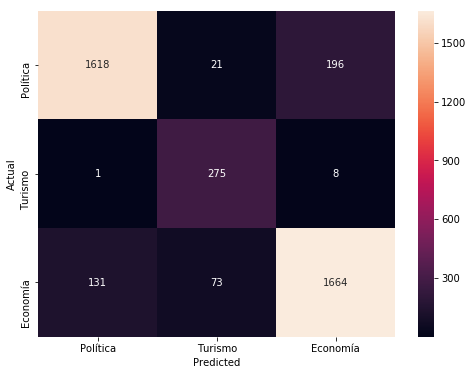

In [72]:
#y_pred = model.predict(X_test)

conf_mat = confusion_matrix(y_valid_array_clase, y_prediction_clase)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=p_clases, yticklabels=p_clases)
           
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [119]:
print(classification_report(y_valid_array_clase, y_prediction_clase, 
                                    target_names=p_clases))

             precision    recall  f1-score   support

   Política       0.95      0.84      0.89      1835
    Turismo       0.68      0.97      0.80       284
   Economía       0.87      0.91      0.89      1868

avg / total       0.89      0.88      0.88      3987



## Obtenemos entonces un accuracy del 89% para un dataframe del año siguiente